In [1]:
# Visualisasi
import matplotlib; import matplotlib.pyplot as plt 

# Pengoperasian gambar
import cv2
import numpy as np

print("matplotlib=="+ matplotlib.__version__)
print("opencv=="+ cv2.__version__)
print("numpy=="+ np.__version__)

matplotlib==3.10.6
opencv==4.12.0
numpy==2.2.6


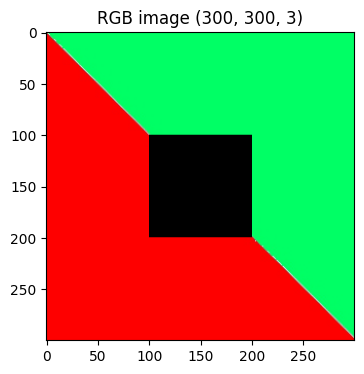

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Ambil citra
img = cv2.imread("F:/Universitas Brawijaya/Semester Pendek/citra komputer/TugasKlpk/tugas_kel_pcdvk-1/image_inpanting/masked_center.png")

# Konversi BGR ke RGB 
imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Konversi ke grayscale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Tampilkan hasil
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(imgrgb)
plt.title(f"RGB image {imgrgb.shape}")
plt.axis("on")

plt.show()


Image exists?  True
Mask exists?   True


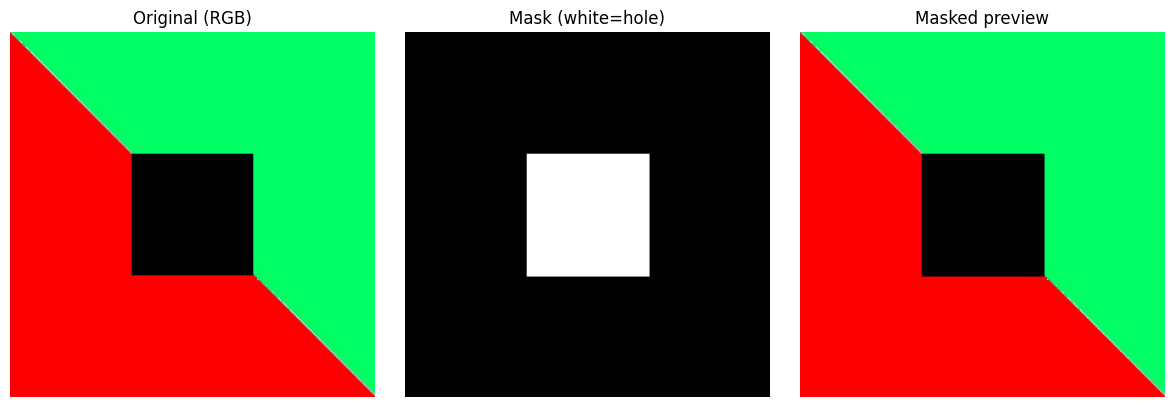

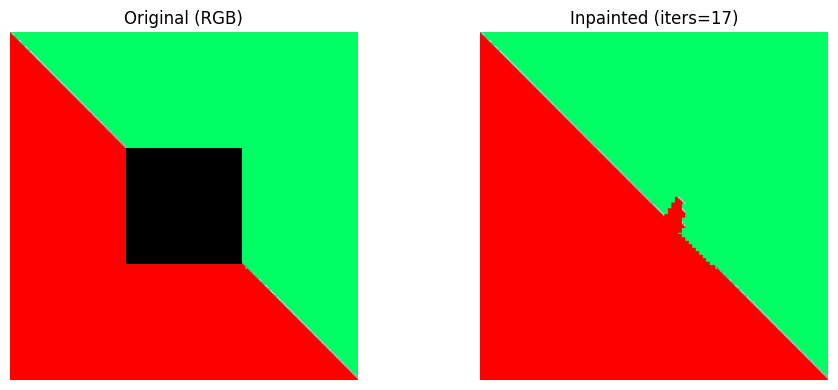

In [8]:
# --- RGB Patch-based Inpainting (mean-based similarity) ---
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ----------------- helpers -----------------
def load_rgb(path_img: Path, path_mask: Path):
    img_bgr = cv2.imread(str(path_img))
    if img_bgr is None:
        raise FileNotFoundError(f"Can't read image: {path_img}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(path_mask), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Can't read mask: {path_mask}")

    # match sizes
    if mask.shape[:2] != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 0 = known, 255 = hole
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return img_rgb, mask_bin

def extract_patch(img, center, k):
    r = k // 2
    y, x = center
    h, w = img.shape[:2]
    if y - r < 0 or x - r < 0 or y + r >= h or x + r >= w:
        return None, None
    return img[y-r:y+r+1, x-r:x+r+1].copy(), (y-r, x-r)

def frontier(mask):
    ker = np.ones((3,3), np.uint8)
    dil = cv2.dilate(mask, ker, iterations=1)
    edge = (dil == 255) & (mask == 0)
    ys, xs = np.where(edge)
    return list(zip(ys, xs))

def inpaint_patch_mean(img_rgb, mask_bin, k=7, max_iters=2000):
    img = img_rgb.copy()
    mask = mask_bin.copy()
    r = k // 2
    H, W = img.shape[:2]

    # reference patches: fully known k×k windows
    ref_centers = []
    for y in range(r, H-r):
        for x in range(r, W-r):
            if np.all(mask[y-r:y+r+1, x-r:x+r+1] == 0):
                ref_centers.append((y, x))
    if not ref_centers:
        raise RuntimeError("No fully-known reference patches found. Shrink k or adjust mask.")

    ref_patches = np.stack([img[y-r:y+r+1, x-r:x+r+1] for (y, x) in ref_centers], axis=0)  # (Nref, k, k, 3)

    it = 0
    while np.any(mask == 255) and it < max_iters:
        it += 1
        fringe = frontier(mask)
        if not fringe:
            break

        filled_this_round = 0
        for (y, x) in fringe:
            Pt, (ty, tx) = extract_patch(img, (y, x), k)
            if Pt is None:
                continue
            Mt = mask[ty:ty+k, tx:tx+k]
            if not np.any(Mt == 255):
                continue

            known = (Mt == 0)
            if not np.any(known):
                continue

            ky, kx = np.where(known)
            Pr_known = ref_patches[:, ky, kx, :]          # (Nref, n_known, 3)
            Pt_known = Pt[known]                          # (n_known, 3)
            dists = np.mean(np.abs(Pr_known - Pt_known[None, :, :]), axis=(1,2))  # mean-based similarity
            best_patch = ref_patches[int(np.argmin(dists))]

            unknown = (Mt == 255)
            uy, ux = np.where(unknown)
            if uy.size:
                img[ty+uy, tx+ux] = best_patch[uy, ux]
                mask[ty+uy, tx+ux] = 0
                filled_this_round += uy.size

        if filled_this_round == 0:
            break

    return img, mask, it

# ----------------- YOUR ABSOLUTE PATHS -----------------
IMG_PATH  = Path(r"F:/Universitas Brawijaya/Semester Pendek/citra komputer/TugasKlpk/tugas_kel_pcdvk-1/image_inpanting/masked_center.png")
MASK_PATH = Path(r"F:/Universitas Brawijaya/Semester Pendek/citra komputer/TugasKlpk/tugas_kel_pcdvk-1/image_inpanting/empty_mask.png")

# (Optional) quick existence check
print("Image exists? ", IMG_PATH.exists())
print("Mask exists?  ", MASK_PATH.exists())

# Load
img_rgb, mask_bin = load_rgb(IMG_PATH, MASK_PATH)

# Phase 1: visualize inputs
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);                 plt.title("Original (RGB)");   plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_bin, cmap="gray");   plt.title("Mask (white=hole)");plt.axis("off")
preview = cv2.bitwise_and(img_rgb, img_rgb, mask=cv2.bitwise_not(mask_bin))
plt.subplot(1,3,3); plt.imshow(preview);                 plt.title("Masked preview");   plt.axis("off")
plt.tight_layout(); plt.show()

# Phase 2: inpaint
inpainted_rgb, out_mask, iters = inpaint_patch_mean(img_rgb, mask_bin, k=7, max_iters=5000)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_rgb);        plt.title("Original (RGB)");          plt.axis("off")
plt.subplot(1,2,2); plt.imshow(inpainted_rgb);  plt.title(f"Inpainted (iters={iters})"); plt.axis("off")
plt.tight_layout(); plt.show()



Image exists?  True
Mask exists?   True


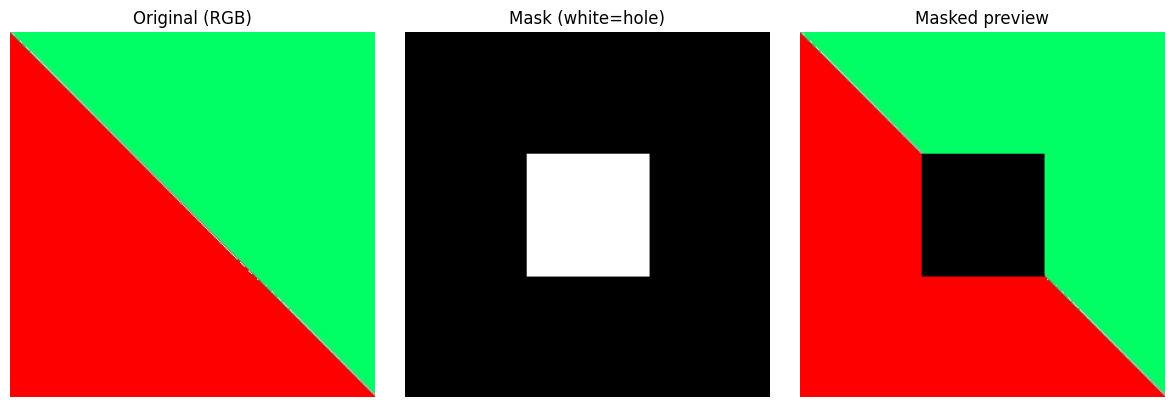

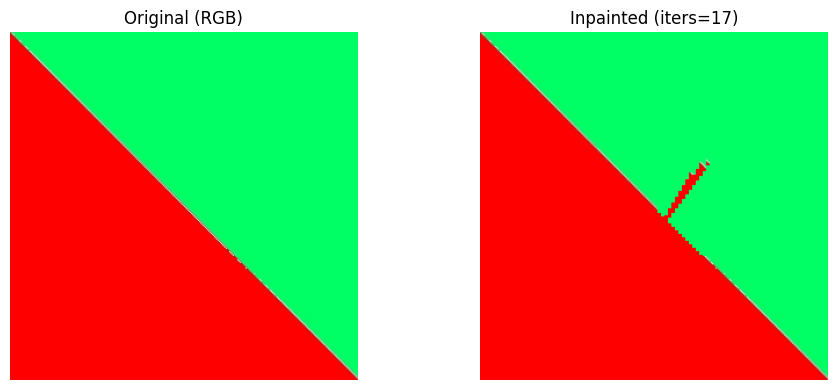

In [ ]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_rgb(path_img: Path, path_mask: Path):
    img_bgr = cv2.imread(str(path_img))
    if img_bgr is None:
        raise FileNotFoundError(f"Can't read image: {path_img}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(path_mask), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Can't read mask: {path_mask}")

    # match sizes
    if mask.shape[:2] != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 0 = known, 255 = hole
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return img_rgb, mask_bin

def extract_patch(img, center, k):
    r = k // 2
    y, x = center
    h, w = img.shape[:2]
    if y - r < 0 or x - r < 0 or y + r >= h or x + r >= w:
        return None, None
    return img[y-r:y+r+1, x-r:x+r+1].copy(), (y-r, x-r)

def frontier(mask):
    ker = np.ones((3,3), np.uint8)
    dil = cv2.dilate(mask, ker, iterations=1)
    edge = (dil == 255) & (mask == 0)
    ys, xs = np.where(edge)
    return list(zip(ys, xs))

def inpaint_patch_mean(img_rgb, mask_bin, k=7, max_iters=2000):
    img = img_rgb.copy()
    mask = mask_bin.copy()
    r = k // 2
    H, W = img.shape[:2]

    # reference patches: fully known k×k windows
    ref_centers = []
    for y in range(r, H-r):
        for x in range(r, W-r):
            if np.all(mask[y-r:y+r+1, x-r:x+r+1] == 0):
                ref_centers.append((y, x))
    if not ref_centers:
        raise RuntimeError("No fully-known reference patches found. Shrink k or adjust mask.")

    ref_patches = np.stack([img[y-r:y+r+1, x-r:x+r+1] for (y, x) in ref_centers], axis=0)  # (Nref, k, k, 3)

    it = 0
    while np.any(mask == 255) and it < max_iters:
        it += 1
        fringe = frontier(mask)
        if not fringe:
            break

        filled_this_round = 0
        for (y, x) in fringe:
            Pt, (ty, tx) = extract_patch(img, (y, x), k)
            if Pt is None:
                continue
            Mt = mask[ty:ty+k, tx:tx+k]
            if not np.any(Mt == 255):
                continue

            known = (Mt == 0)
            if not np.any(known):
                continue

            ky, kx = np.where(known)
            Pr_known = ref_patches[:, ky, kx, :]          # (Nref, n_known, 3)
            Pt_known = Pt[known]                          # (n_known, 3)
            dists = np.mean(np.abs(Pr_known - Pt_known[None, :, :]), axis=(1,2))  # mean-based similarity
            best_patch = ref_patches[int(np.argmin(dists))]

            unknown = (Mt == 255)
            uy, ux = np.where(unknown)
            if uy.size:
                img[ty+uy, tx+ux] = best_patch[uy, ux]
                mask[ty+uy, tx+ux] = 0
                filled_this_round += uy.size

        if filled_this_round == 0:
            break

    return img, mask, it

IMG_PATH  = Path("merah_hijau.jpg")
MASK_PATH = Path("empty_mask.png")

# Load
img_rgb, mask_bin = load_rgb(IMG_PATH, MASK_PATH)

# Phase 1: visualize inputs
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);                 plt.title("Original (RGB)");   plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_bin, cmap="gray");   plt.title("Mask (white=hole)");plt.axis("off")
preview = cv2.bitwise_and(img_rgb, img_rgb, mask=cv2.bitwise_not(mask_bin))
plt.subplot(1,3,3); plt.imshow(preview);                 plt.title("Masked preview");   plt.axis("off")
plt.tight_layout(); plt.show()

# Phase 2: inpaint
inpainted_rgb, out_mask, iters = inpaint_patch_mean(img_rgb, mask_bin, k=7, max_iters=5000)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_rgb);        plt.title("Original (RGB)");          plt.axis("off")
plt.subplot(1,2,2); plt.imshow(inpainted_rgb);  plt.title(f"Inpainted (iters={iters})"); plt.axis("off")
plt.tight_layout(); plt.show()


Image exists?  True
Mask exists?   True


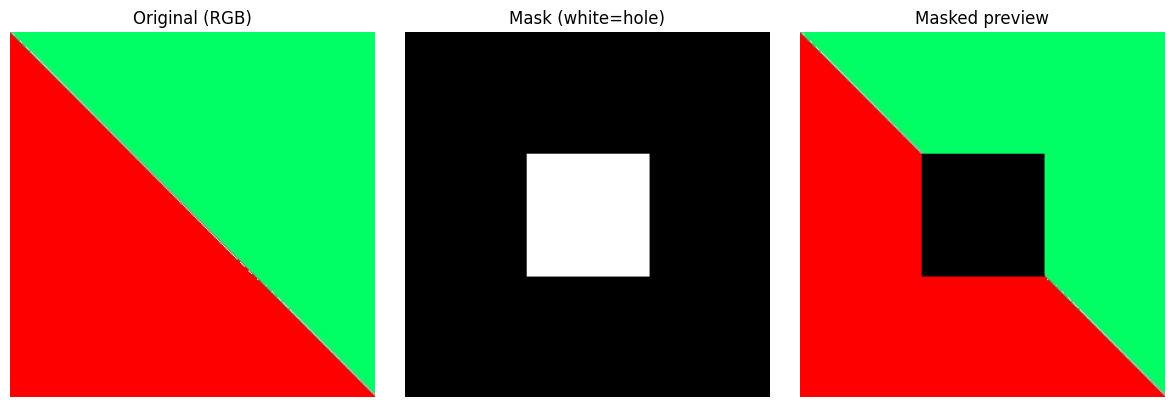

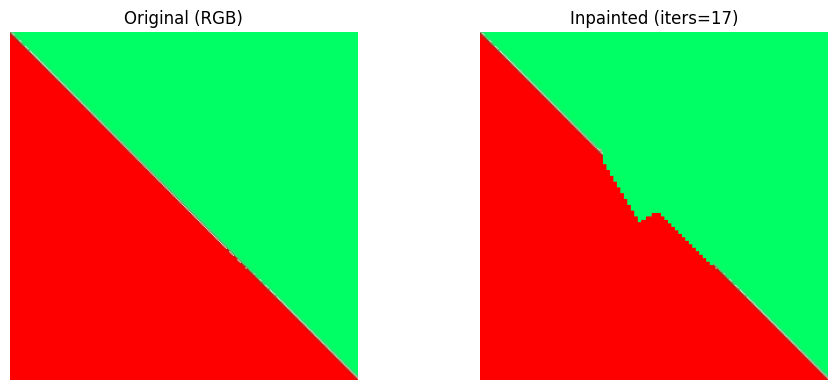

In [4]:
# === RGB Patch-based Inpainting (Notebook-like: stride harvesting + padding) ===
# Methods mirrored from your older notebook, but fully RGB and end-to-end.
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, List

# -------------------- I/O helpers --------------------
def load_rgb_and_mask(img_path: Path | str, mask_path: Path | str):
    """Load an RGB image (no grayscale conversion) and a single-channel mask (white=hole)."""
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Cannot read mask: {mask_path}")

    if mask.shape[:2] != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # binarize: 255 = hole, 0 = known
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return img_rgb, mask_bin

# -------------------- padding & patch utils --------------------
def extract_patch_padded(img: np.ndarray, center: Tuple[int,int], k: int, mode: str = "edge"):
    """
    Extract a k×k RGB patch centered at (y,x).
    If near borders, pad so we always return a k×k patch.
    mode: "edge" uses BORDER_REPLICATE (more natural than zeros).
    Returns (patch, top_left_in_img)
    """
    r = k // 2
    y, x = center
    H, W = img.shape[:2]

    # compute needed padding on each side
    pad_top    = max(0, r - y)
    pad_left   = max(0, r - x)
    pad_bottom = max(0, y + r + 1 - H)
    pad_right  = max(0, x + r + 1 - W)

    if pad_top or pad_left or pad_bottom or pad_right:
        border = cv2.BORDER_REPLICATE if mode == "edge" else cv2.BORDER_CONSTANT
        pad_val = (0,0,0) if mode != "edge" else 0
        padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, border, value=pad_val)
        y2, x2 = y + pad_top, x + pad_left
        patch = padded[y2 - r:y2 + r + 1, x2 - r:x2 + r + 1].copy()
        # top-left in original image coords (clamped)
        top_left = (max(0, y - r), max(0, x - r))
        return patch, top_left
    else:
        return img[y - r:y + r + 1, x - r:x + r + 1].copy(), (y - r, x - r)

def extract_mask_window_padded(mask: np.ndarray, top_left: Tuple[int,int], k: int):
    """Get a k×k window from mask aligned with patch top-left; pads if needed."""
    ty, tx = top_left
    H, W = mask.shape[:2]
    y2, x2 = ty + k, tx + k

    pad_top    = max(0, 0 - ty)
    pad_left   = max(0, 0 - tx)
    pad_bottom = max(0, y2 - H)
    pad_right  = max(0, x2 - W)

    if pad_top or pad_left or pad_bottom or pad_right:
        padded = cv2.copyMakeBorder(
            mask, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_REPLICATE
        )
        ty2, tx2 = ty + pad_top, tx + pad_left
        return padded[ty2:ty2 + k, tx2:tx2 + k].copy()
    else:
        return mask[ty:ty + k, tx:tx + k].copy()

# -------------------- frontier (fill boundary) --------------------
def frontier(mask: np.ndarray) -> List[Tuple[int,int]]:
    """Return (y,x) positions on the boundary just outside the hole."""
    ker = np.ones((3,3), np.uint8)
    dil = cv2.dilate(mask, ker, iterations=1)
    edge = (dil == 255) & (mask == 0)  # known pixels adjacent to hole
    ys, xs = np.where(edge)
    return list(zip(ys, xs))

# -------------------- reference patch harvesting (stride) --------------------
def harvest_ref_patches_stride(img_rgb: np.ndarray, mask: np.ndarray, k: int, stride: int = 10, max_refs: int | None = None):
    """
    Collect k×k RGB patches whose windows are fully known (mask==0) using a sampling stride.
    Returns array of shape (Nref, k, k, 3).
    """
    r = k // 2
    H, W = img_rgb.shape[:2]
    refs = []

    for y in range(r, H - r, stride):
        for x in range(r, W - r, stride):
            win = mask[y - r:y + r + 1, x - r:x + r + 1]
            if np.all(win == 0):
                refs.append(img_rgb[y - r:y + r + 1, x - r:x + r + 1].copy())
                if max_refs is not None and len(refs) >= max_refs:
                    break
        if max_refs is not None and len(refs) >= max_refs:
            break

    if not refs:
        raise RuntimeError("No fully-known reference patches found. Reduce k or stride, or fix the mask.")
    return np.stack(refs, axis=0)  # (Nref, k, k, 3)

# -------------------- similarity: mean absolute difference on known overlap --------------------
def mean_abs_diff_known(Pt: np.ndarray, Mt: np.ndarray, Pr: np.ndarray) -> float:
    """
    Compute mean absolute difference between target patch Pt and reference patch Pr,
    but only on positions where Mt==0 (known pixels). RGB-aware.
    """
    known = (Mt == 0)
    if not np.any(known):
        return np.inf
    # known is 2D; Pt/Pr are (k,k,3) -> index known rows/cols then all 3 channels
    ky, kx = np.where(known)
    Pt_known = Pt[ky, kx, :]            # (N_known, 3)
    Pr_known = Pr[ky, kx, :]            # (N_known, 3)
    return float(np.abs(Pt_known - Pr_known).mean())

# -------------------- main inpainting loop (stride + padding) --------------------
def inpaint_rgb_patch_stride(img_rgb: np.ndarray, mask_bin: np.ndarray,
                             k: int = 7, stride: int = 10, max_iters: int = 3000,
                             max_refs: int | None = None, pad_mode: str = "edge"):
    """
    RGB exemplar inpainting using:
      - stride-based harvesting of reference patches (faster, notebook-like)
      - padding-aware patch extraction (edge-friendly)
      - frontier-driven filling
      - mean-based similarity over known pixels
    """
    img = img_rgb.copy()
    mask = mask_bin.copy()
    r = k // 2

    # 1) harvest reference patches once (dictionary)
    ref_patches = harvest_ref_patches_stride(img, mask, k, stride=stride, max_refs=max_refs)

    it = 0
    while np.any(mask == 255) and it < max_iters:
        it += 1
        boundary = frontier(mask)
        if not boundary:
            break

        filled = 0

        # (Optional) shuffle to reduce directional bias
        # np.random.shuffle(boundary)

        for (y, x) in boundary:
            # 2) target patch + local mask (padding-aware)
            Pt, top_left = extract_patch_padded(img, (y, x), k, mode=pad_mode)
            Mt = extract_mask_window_padded(mask, top_left, k)

            # skip if nothing to fill in this window
            if not np.any(Mt == 255):
                continue

            # 3) compute distance against all refs (MAD on known overlap), pick best
            # vectorized form to speed up a bit:
            known = (Mt == 0)
            if not np.any(known):
                continue
            ky, kx = np.where(known)           # (n_known,)
            Pt_known = Pt[ky, kx, :]           # (n_known, 3)
            # shape: (Nref, n_known, 3)
            Pr_known = ref_patches[:, ky, kx, :]
            dists = np.mean(np.abs(Pr_known - Pt_known[None, :, :]), axis=(1, 2))  # (Nref,)
            best = ref_patches[int(np.argmin(dists))]

            # 4) copy unknown pixels from the best match
            uy, ux = np.where(Mt == 255)
            if uy.size:
                img[top_left[0] + uy, top_left[1] + ux] = best[uy, ux]
                mask[top_left[0] + uy, top_left[1] + ux] = 0
                filled += uy.size

        if filled == 0:
            # no progress → try larger k or different stride
            break

    return img, mask, it

# -------------------- run --------------------
# Set your file names here (relative to notebook) or absolute paths with r"F:\...":
IMG_PATH  = Path("merah_hijau.jpg")
MASK_PATH = Path("empty_mask.png")

print("Image exists? ", IMG_PATH.exists())
print("Mask exists?  ", MASK_PATH.exists())

img_rgb, mask_bin = load_rgb_and_mask(IMG_PATH, MASK_PATH)

# Phase 1: visualize inputs
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);               plt.title("Original (RGB)");    plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_bin, cmap="gray"); plt.title("Mask (white=hole)"); plt.axis("off")
preview = cv2.bitwise_and(img_rgb, img_rgb, mask=cv2.bitwise_not(mask_bin))
plt.subplot(1,3,3); plt.imshow(preview);               plt.title("Masked preview");    plt.axis("off")
plt.tight_layout(); plt.show()

# Phase 2: inpaint (mimics notebook: stride + padding)
inpainted_rgb, out_mask, iters = inpaint_rgb_patch_stride(
    img_rgb, mask_bin, k=7, stride=10, max_iters=4000, max_refs=None, pad_mode="edge"
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_rgb);        plt.title("Original (RGB)");             plt.axis("off")
plt.subplot(1,2,2); plt.imshow(inpainted_rgb);  plt.title(f"Inpainted (iters={iters})"); plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- User params (edit these) ----
IMG_PATH  = Path("merah_hijau.jpg")     # or r"F:\...\merah_hijau.jpg"
MASK_PATH = Path("empty_mask.png")      # or r"F:\...\empty_mask.png"

k         = 7       # patch size (odd): 5,7,9...
stride    = 10      # stride for harvesting reference patches (larger = faster)
pad_mode  = "constant"  # "edge" (replicate) or "constant" (zeros) for padding
max_iters = 3000    # safety cap on iterations
max_refs  = None    # limit reference patches (e.g., 5000) or None for all sampled

np.set_printoptions(suppress=True)
print("Params:", dict(k=k, stride=stride, pad_mode=pad_mode, max_iters=max_iters, max_refs=max_refs))


Params: {'k': 7, 'stride': 10, 'pad_mode': 'constant', 'max_iters': 3000, 'max_refs': None}


Image exists?  True
Mask exists?   True


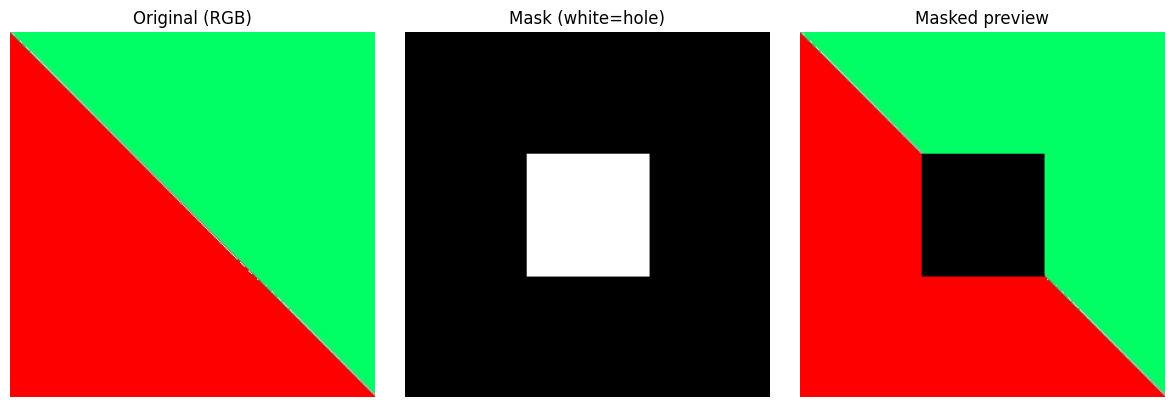

In [ ]:
def load_rgb_and_mask(img_path: Path | str, mask_path: Path | str):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Cannot read mask: {mask_path}")

    if mask.shape[:2] != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 255 = hole, 0 = known
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return img_rgb, mask_bin

print("Image exists? ", IMG_PATH.exists())
print("Mask exists?  ", MASK_PATH.exists())

img_rgb, mask_bin = load_rgb_and_mask(IMG_PATH, MASK_PATH)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);               plt.title("Original (RGB)");    plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_bin, cmap="gray"); plt.title("Mask (white=hole)"); plt.axis("off")
preview = cv2.bitwise_and(img_rgb, img_rgb, mask=cv2.bitwise_not(mask_bin))
plt.subplot(1,3,3); plt.imshow(preview);               plt.title("Masked preview");    plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
from typing import Tuple, List

def extract_patch_padded(img: np.ndarray, center: Tuple[int,int], k: int, mode: str = "edge"):
    """Return k×k RGB patch centered at (y,x); pads near borders so you always get k×k."""
    r = k // 2
    y, x = center
    H, W = img.shape[:2]

    pad_top    = max(0, r - y)
    pad_left   = max(0, r - x)
    pad_bottom = max(0, y + r + 1 - H)
    pad_right  = max(0, x + r + 1 - W)

    if pad_top or pad_left or pad_bottom or pad_right:
        border = cv2.BORDER_REPLICATE if mode == "edge" else cv2.BORDER_CONSTANT
        pad_val = (0,0,0) if mode != "edge" else 0
        padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, border, value=pad_val)
        y2, x2 = y + pad_top, x + pad_left
        patch = padded[y2 - r:y2 + r + 1, x2 - r:x2 + r + 1].copy()
        top_left = (max(0, y - r), max(0, x - r))
        return patch, top_left
    else:
        return img[y - r:y + r + 1, x - r:x + r + 1].copy(), (y - r, x - r)

def extract_mask_window_padded(mask: np.ndarray, top_left: Tuple[int,int], k: int):
    """Return k×k mask window aligned with patch top-left; pads near borders."""
    ty, tx = top_left
    H, W = mask.shape[:2]
    y2, x2 = ty + k, tx + k

    pad_top    = max(0, 0 - ty)
    pad_left   = max(0, 0 - tx)
    pad_bottom = max(0, y2 - H)
    pad_right  = max(0, x2 - W)

    if pad_top or pad_left or pad_bottom or pad_right:
        padded = cv2.copyMakeBorder(mask, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_REPLICATE)
        ty2, tx2 = ty + pad_top, tx + pad_left
        return padded[ty2:ty2 + k, tx2:tx2 + k].copy()
    else:
        return mask[ty:ty + k, tx:tx + k].copy()

def frontier(mask: np.ndarray) -> List[Tuple[int,int]]:
    """Return positions (y,x) that are known but directly touch the hole (the fill boundary)."""
    ker = np.ones((3,3), np.uint8)
    dil = cv2.dilate(mask, ker, iterations=1)
    edge = (dil == 255) & (mask == 0)  # known pixels adjacent to hole
    ys, xs = np.where(edge)
    return list(zip(ys, xs))


Harvested refs: 779 patches of size 7x7 in 0.008s


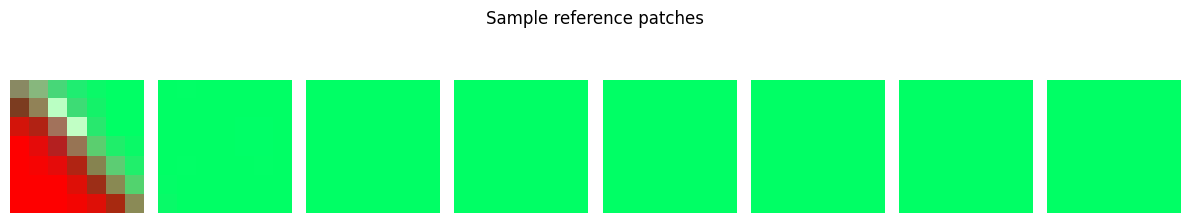

In [ ]:
def harvest_ref_patches_stride(img_rgb: np.ndarray, mask: np.ndarray, k: int, stride: int = 10, max_refs: int | None = None):
    """
    Collect k×k RGB patches whose windows are fully known (mask==0) using a sampling stride.
    Returns array of shape (Nref, k, k, 3).
    """
    r = k // 2
    H, W = img_rgb.shape[:2]
    refs = []

    for y in range(r, H - r, stride):
        for x in range(r, W - r, stride):
            win = mask[y - r:y + r + 1, x - r:x + r + 1]
            if np.all(win == 0):
                refs.append(img_rgb[y - r:y + r + 1, x - r:x + r + 1].copy())
                if max_refs is not None and len(refs) >= max_refs:
                    break
        if max_refs is not None and len(refs) >= max_refs:
            break

    if not refs:
        raise RuntimeError("No fully-known reference patches found. Reduce k/stride, or adjust mask.")
    return np.stack(refs, axis=0)

t0 = time.time()
ref_patches = harvest_ref_patches_stride(img_rgb, mask_bin, k=k, stride=stride, max_refs=max_refs)
t1 = time.time()
print(f"Harvested refs: {ref_patches.shape[0]} patches of size {k}x{k} in {t1 - t0:.3f}s")

# Peek a few reference patches
n_show = min(8, ref_patches.shape[0])
plt.figure(figsize=(12,2.5))
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    plt.imshow(ref_patches[i])
    plt.axis("off")
plt.suptitle("Sample reference patches")
plt.tight_layout(); plt.show()


In [ ]:
def step_inpaint(img: np.ndarray, mask: np.ndarray, ref_patches: np.ndarray, k: int, pad_mode: str = "edge"):
    """
    Do ONE iteration over the current frontier:
      - build frontier
      - for each boundary point: extract target patch, compute MAD vs all refs (on known overlap)
      - copy unknown pixels from best match
    Returns: (img_new, mask_new, filled_pixels_this_step)
    """
    img = img.copy()
    mask = mask.copy()
    boundary = frontier(mask)
    if not boundary:
        return img, mask, 0

    filled = 0

    for (y, x) in boundary:
        Pt, top_left = extract_patch_padded(img, (y, x), k, mode=pad_mode)
        Mt = extract_mask_window_padded(mask, top_left, k)

        # nothing to fill here
        if not np.any(Mt == 255):
            continue

        # known overlap positions
        known = (Mt == 0)
        if not np.any(known):
            continue

        ky, kx = np.where(known)
        Pt_known = Pt[ky, kx, :]                # (n_known, 3)
        Pr_known = ref_patches[:, ky, kx, :]    # (Nref, n_known, 3)

        # mean absolute difference over known overlap (RGB)
        dists = np.mean(np.abs(Pr_known - Pt_known[None, :, :]), axis=(1, 2))
        best = ref_patches[int(np.argmin(dists))]

        # copy only unknown pixels
        uy, ux = np.where(Mt == 255)
        if uy.size:
            img[top_left[0] + uy, top_left[1] + ux] = best[uy, ux]
            mask[top_left[0] + uy, top_left[1] + ux] = 0
            filled += uy.size

    return img, mask, filled


In [ ]:
img_work = img_rgb.copy()
mask_work = mask_bin.copy()

t_start = time.time()
history = []
for it in range(1, max_iters + 1):
    img_work, mask_work, filled = step_inpaint(img_work, mask_work, ref_patches, k=k, pad_mode=pad_mode)
    history.append(filled)

    # progress print every few iterations
    if it % 10 == 0 or filled == 0:
        remaining = int(np.sum(mask_work == 255))
        print(f"iter {it:4d} | filled this step: {filled:5d} | remaining hole pixels: {remaining}")
    # quick preview every N iterations
    if it % 50 == 0 or filled == 0:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(img_work); plt.title(f"Preview after iter {it}"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(mask_work, cmap="gray"); plt.title("Mask"); plt.axis("off")
        plt.tight_layout(); plt.show()

    if filled == 0 or not np.any(mask_work == 255):
        break

t_total = time.time() - t_start
print(f"Done in {it} iterations, {t_total:.2f}s total.")


iter   10 | filled this step:   528 | remaining hole pixels: 1681
Done in 17 iterations, 3.70s total.


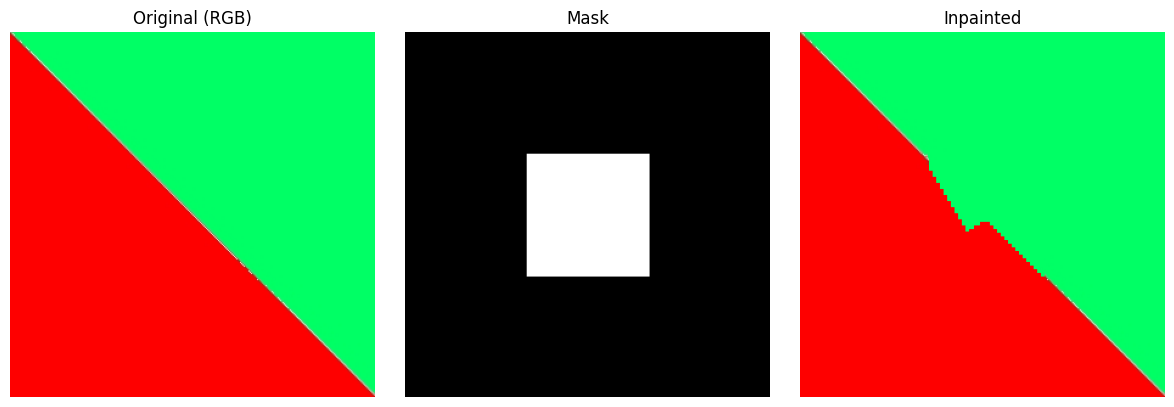

Saved: F:\Universitas Brawijaya\Semester Pendek\citra komputer\TugasKlpk\tugas_kel_pcdvk-1\image_inpanting\inpainted_rgb_stride.png


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);     plt.title("Original (RGB)");  plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_bin, cmap="gray"); plt.title("Mask");  plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img_work);    plt.title("Inpainted");       plt.axis("off")
plt.tight_layout(); plt.show()

# Optional save
out_path = Path("inpainted_rgb_stride.png")
cv2.imwrite(str(out_path), cv2.cvtColor(img_work, cv2.COLOR_RGB2BGR))
print("Saved:", out_path.resolve())
